In [1]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import keras.utils as image

In [2]:
images = glob.glob('img_align_celeba/img_align_celeba/*.jpg')

In [3]:
print(len(images))

202599


In [4]:
images=images[0:1000]

In [5]:
#image=images[0]
img = image.load_img('img_align_celeba/img_align_celeba\\000001.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

In [6]:
img

array([[[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [0.80784315, 0.72156864, 0.4862745 ],
        [1.        , 0.92941177, 0.85490197],
        [0.99607843, 0.93333334, 0.87058824]],

       [[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [0.94509804, 0.8666667 , 0.6666667 ],
        [0.96862745, 0.9019608 , 0.83137256],
        [0.99607843, 0.93333334, 0.87058824]],

       [[0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        [0.99215686, 0.90588236, 0.7607843 ],
        ...,
        [1.        , 0.9411765 , 0.78431374],
        [0.9529412 , 0.8901961 , 0.827451  ],
        [0.9843137 , 0.92156863, 0.85882354]],

       ...,

       [[0.6039216 , 0.35686275, 0.15686275],
        [0.8666667 , 0.6039216 , 0.42745098],
        [0.57254905, 0

In [7]:
from tqdm import tqdm
progress = tqdm(total= len(images), position=0)
def read(paths):
    res=[]
    for path in paths:
      img = image.load_img(path, target_size=(80,80,3))
      img = image.img_to_array(img)
      img = img/255.
      progress.update(1)
      res.append(img)
    return res

img_array=read(images)

 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [00:00<00:00, 1173.29it/s]

In [8]:
len(img_array)

1000

In [9]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [10]:
def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)
  low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
  return low_res_image

In [11]:
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images


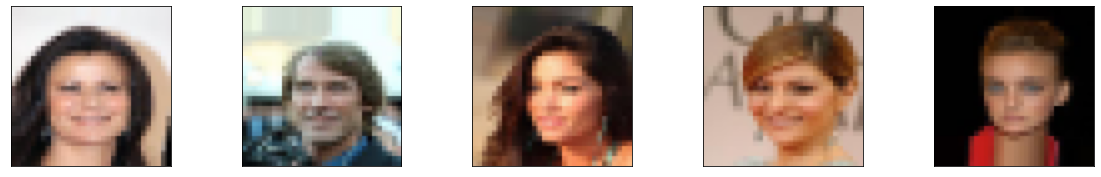

In [12]:
n=5
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 80, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 40, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [14]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

In [15]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/100
 3/25 [==>...........................] - ETA: 1:24 - loss: 0.2368 - accuracy: 0.0788

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 1173.29it/s]

25/25 [==============================] - 114s 5s/step - loss: 0.1137 - accuracy: 0.2715 - val_loss: 0.0193 - val_accuracy: 0.7389
Epoch 2/100
25/25 [==============================] - 105s 4s/step - loss: 0.0099 - accuracy: 0.7617 - val_loss: 0.0058 - val_accuracy: 0.7934
Epoch 3/100
25/25 [==============================] - 101s 4s/step - loss: 0.0048 - accuracy: 0.8262 - val_loss: 0.0041 - val_accuracy: 0.8589
Epoch 4/100
25/25 [==============================] - 83s 3s/step - loss: 0.0039 - accuracy: 0.8475 - val_loss: 0.0036 - val_accuracy: 0.8612
Epoch 5/100
25/25 [==============================] - 83s 3s/step - loss: 0.0036 - accuracy: 0.8678 - val_loss: 0.0035 - val_accuracy: 0.8782
Epoch 6/100
25/25 [==============================] - 83s 3s/step - loss: 0.0035 - accuracy: 0.8761 - val_loss: 0.0034 - val_accuracy: 0.8763
Epoch 7/100
25/25 [==============================] - 83s 3s/step - loss: 0.0034 - accuracy: 0.8841 - val_loss: 0.0032 - val_accuracy: 0.9032
Epoch 8/100
25/25 [===

In [16]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

7/7 [==============================] - 5s 653ms/step - loss: 0.0026 - accuracy: 0.8931
val_loss, val_accuracy [0.0026154369115829468, 0.8930851817131042]


7/7 [==============================] - 5s 637ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


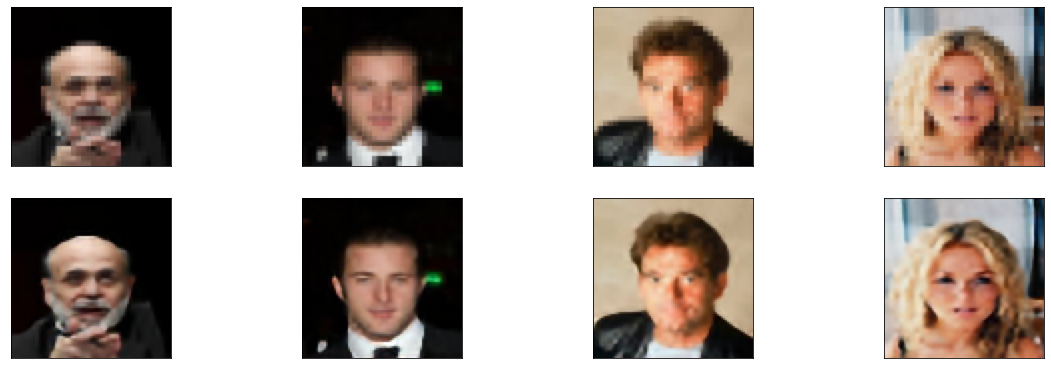

In [17]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
fake_image=predictions[20]
hr_image=val_x_px[20]
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)

PSNR Achieved: 74.266418


In [20]:
def MSE(img1, img2):
        squared_diff = (img1 -img2) ** 2
        summed = np.sum(squared_diff)
        num_pix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
        err = summed / num_pix
        return err
error=MSE(fake_image,hr_image)
error

0.007303977012634277